# Almgren-Chriss Optimal Execution - Efficient Frontier approach

## Syllabus

1. Almgren-Chriss framework
2. Efficient frontier for implementation shortfall
3. Efficient frontier for VWAP
4. Efficient forntier for TWAP

## 1. Almgren-Chriss framework

The **Almgren-Chriss framework** (1999) is a mathematical model that looks to

- Estimate the optimal pace to build/unwind a trading position, issues often faced by brokers and traders (but has not seen as much interest from statisticians, economists and econophysicists in the past decades);
- Allows one to graphically represent the trade-off between slow/fast execution;
- Ease to choose one's own prefered approach to model market impact costs;
- Avoids the temptation of modelling the market as a physical system fully enclosed in its own data (*physics envy*);
- Designed from a bottom-top approach: the modelling is based on the execution process itself;
- Provides a multitude of modelling approaches to compute the slow/fast execution trade-off (e.g. dynamic programming, stochastic control, reinforcement learning, etc.).

We will present 2 approaches to solve the Almgren-Chriss model:

1. Efficient Frontier (original method)
2. Dynamic Programming

**Assumptions**

- *Trading trajectory*

$$ x_0 = X $$

$$ n_k = x_k - x_{k-1} $$

$$ x_k = X - \sum_{j=1}^k n_j = \sum_{j=k+1}^N n_k, \, \, \, \,\, \, \,\, \, \,   k=0,...,N $$

- *Price trajectory*

$$ S_k = S_{k-1} + \sigma  \sqrt{\tau} \zeta_k - \tau g(\frac{n_k}{\tau}) $$

$$ g(v) = \gamma v $$

$$ S_k = S_0 + \sigma  \sqrt{\tau} \sum_{j=1}^k \zeta_j - \gamma (X - x_k) $$

- *Temporary market impact*

$$ h(v) = \varepsilon sign(n_i) + \frac{\eta}{\tau} n_i $$

$$ \tilde S_k = S_{k-1} - h(\frac{n_k}{\tau}) $$

In [1]:
import numpy as np

# Utilities

def g(x, gamma=1.0):
    """
    Permanent market impact.
    """
    return gamma * x

def h(x, tau=1.0, epsilon=1.0, eta=1.0):
    """
    Temporary market impact.
    """
    return epsilon*np.sign(x) + eta*(x/tau)

## 2. Efficient frontier for implementation shortfall

### 2.1. Optimization

**Moments**

$$ X_N = X S_0 - \sum_{i=1}^N n_i \tilde S_i $$

$$ \mathbb{E}(X_N) = \sum_{i=1}^N \tau x_i g(\frac{n_i}{\tau}) + \sum_{i=1}^{N} n_i h(\frac{n_i}{\tau}) = \frac{1}{2} \gamma X^2 + \varepsilon \sum_{i=1}^N |n_i| + \frac{\eta-0.5\gamma \tau}{\tau} \sum_{i=1}^N n_i^2 $$

$$ \mathbb{V}(X_N) = \sigma^2 \sum_{i=1}^N \tau x_i^2 $$

Refresher:

$$ x_t = X - \sum_{j=1}^t n_j = \sum_{j=t+1}^N n_j $$

In [2]:
# Moments

def expectation_IS(N, tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    """
    Expectation of implementation shortfall.
    """
    exp = 0.5*gamma*X**2 + eps*np.sum(N) + (eta - 0.5*gamma*tau)/tau * np.sum(N**2)
    return exp

def variance_IS(N, X=1000, sigma=0.3, tau=1.0):
    """
    Variance of implementation shortfall.
    """
    var = 0
    t = - 1
    while t < len(N) - 1:
        t = t + 1
        temp = (X - np.sum(N[0:t])) ** 2
        var = var + temp
    
    var = tau * (sigma**2) * var
    return var

# Objective function

def objective_IS(N):
    """
    Objective function for implementation shortfall.
    """
    obj = expectation_IS(N) + risk * variance_IS(N)
    return obj

**Optimization**

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_N) + \lambda * \mathbb{V}(X_N) $$

In [3]:
# Parameters
nb_T = 10
x0 = np.zeros((nb_T, 1))
X = 40000
risk = 0.05

# Optimization
from scipy.optimize import minimize

bnds = tuple((0.0, X) for x in range(len(x0)))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})

opt = minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
N_opt = np.array(opt.x)

print('Liquidation trajectory:\n')
print(np.matrix(opt.x.round(0)).T)

print('\nTotal number of shares:')
print(np.sum(opt.x))

Liquidation trajectory:

[[ 3501.]
 [ 3524.]
 [ 3578.]
 [ 3663.]
 [ 3785.]
 [ 3935.]
 [ 4124.]
 [ 4350.]
 [ 4615.]
 [ 4925.]]

Total number of shares:
40000.0


We have the optimal trajectory, now we can detail the liquidation process from the first day till the last:

In [4]:
def liquidation_history(N_opt, X):
    """
    Prints out the liquidation history of the optimal execution.
    """
    hist = np.zeros((len(N_opt)+1, 1))
    hist[0] = X
    
    for i in range(1, len(N_opt)):
        hist[i] = hist[i-1] - N_opt[i]
    
    return hist

hist_opt = liquidation_history(N_opt, X)

print('Liquidation history:\n')
print(hist_opt.round(0))

Liquidation history:

[[ 40000.]
 [ 36476.]
 [ 32898.]
 [ 29235.]
 [ 25450.]
 [ 21515.]
 [ 17391.]
 [ 13041.]
 [  8426.]
 [  3501.]
 [     0.]]


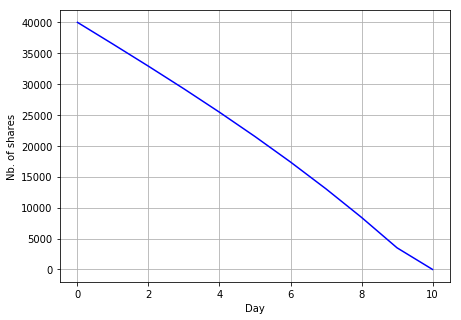

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(hist_opt, color='blue', lw=1.5)
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Nb. of shares')
plt.show()

For the expectation and variance, we get:

In [6]:
print(expectation_IS(N_opt))
print(variance_IS(N_opt))

881134715.505
333217394.515


### 2.2. Hyperparameter testing

In [7]:
def efficient_frontier_IS(X, risk, nb_T, tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    
    def expectation_IS(N):
        """
        Expectation of implementation shortfall.
        """
        exp = 0.5*gamma*X**2 + eps*np.sum(N) + (eta - 0.5*gamma*tau)/tau * np.sum(N**2)
        return exp

    def variance_IS(N, sigma=0.3):
        """
        Variance of implementation shortfall.
        """
        var = 0
        t = - 1
        while t < len(N) - 1:
            t = t + 1
            temp = (X - np.sum(N[0:t])) ** 2
            var = var + temp
        var = tau * (sigma**2) * var
        return var
    
    def objective_IS(N):
        """
        Objective function for implementation shortfall.
        """
        obj = expectation_IS(N) + risk * variance_IS(N)
        return obj
    
    def optimization_IS():
        """
        Optimal execution with optimization for implementation shortfall.
        """
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
        N = np.array(opt.x)
        return N
    
    N_opt = optimization_IS()
    
    def liquidation_history(N_opt, X):
        """
        Prints out the liquidation history of the optimal execution.
        """
        hist = np.zeros((len(N_opt)+1, 1))
        hist[0] = X
        for i in range(1, len(N_opt)):
            hist[i] = hist[i-1] - N_opt[i]
        return hist
    
    hist_opt = liquidation_history(N_opt,X)
    
    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5, marker='o')
        plt.grid(True)
        plt.xlabel('Day')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    plot_liquidation()
    
    return hist_opt.round(0)

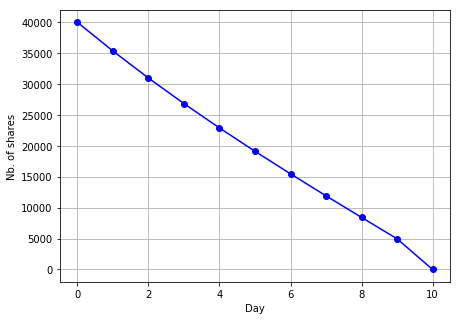

array([[ 40000.],
       [ 35354.],
       [ 30982.],
       [ 26844.],
       [ 22903.],
       [ 19124.],
       [ 15473.],
       [ 11917.],
       [  8423.],
       [  4961.],
       [     0.]])

In [8]:
efficient_frontier_IS(X=40000, risk=0.1, nb_T=10,
                      tau=1.0,
                      gamma=0.002,
                      eta=1.0,
                      eps=1.0)

### 2.3. Efficient frontier